# Project: Detecting contradiction and entailment in multilingual text using TPUs

## Table of Contents:

* [Project description](#description)
* [EDA](#EDA)
* [Prepare data for machine learning](#Prepare)
* [Building the Model](#model)
* [Generating & Submitting Predictions](#Submitting)
* [Conclusion](#Conclusion)


## Project description <a class="anchor" id="description"></a>

If you have two sentences, there are three ways they could be related: one could entail the other, one could contradict the other, or they could be unrelated. Natural Language Inferencing (NLI) is a popular NLP problem that involves determining how pairs of sentences (consisting of a premise and a hypothesis) are related.

Your task is to create an NLI model that assigns labels of 0, 1, or 2 (corresponding to entailment, neutral, and contradiction) to pairs of premises and hypotheses. To make things more interesting, the train and test set include text in fifteen different languages.

This dataset contains premise-hypothesis pairs in fifteen different languages, including:
Arabic, Bulgarian, Chinese, German, Greek, English, Spanish, French, Hindi, Russian, Swahili, Thai, Turkish, Urdu, and Vietnamese.

In [1]:
!pip install nlp


     |████████████████████████████████| 1.7 MB 4.0 MB/s eta 0:00:01


In [2]:
#import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from nlp import load_dataset
from transformers import BertTokenizer, TFBertModel, TFAutoModel,AutoTokenizer
import seaborn as sns


2022-11-02 10:41:35.100146: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-02 10:41:35.100282: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [4]:
os.environ["WANDB_API_KEY"] = "0" ## 0 to silence warning of Weights & Biases


In [5]:
train = pd.read_csv("../input/contradictory-my-dear-watson/train.csv")
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")

In [6]:
#checking for missing values
report = train.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / train.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

,missing_values,% of total
id,0,0.0
premise,0,0.0
hypothesis,0,0.0
lang_abv,0,0.0
language,0,0.0
label,0,0.0


In [7]:
#checking for missing values
report = test.isna().sum().to_frame()
report = report.rename(columns = {0: 'missing_values'})
report['% of total'] = (report['missing_values'] / test.shape[0]).round(2)
report.sort_values(by = 'missing_values', ascending = False)

,missing_values,% of total
id,0,0.0
premise,0,0.0
hypothesis,0,0.0
lang_abv,0,0.0
language,0,0.0


## EDA<a class="anchor" id="EDA"></a>

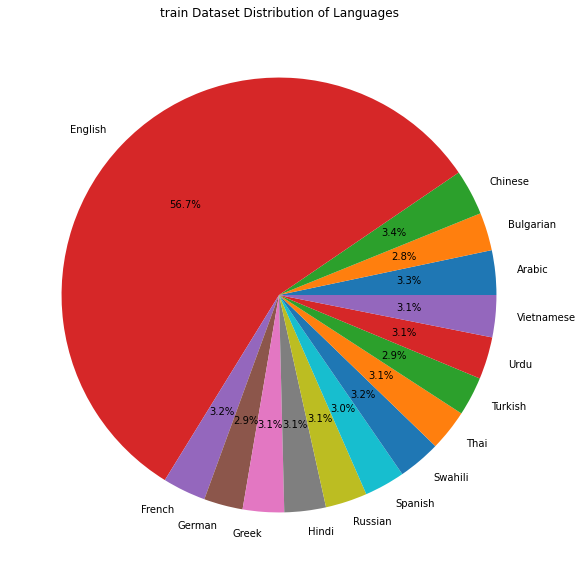

In [8]:
labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.title("train Dataset Distribution of Languages")
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

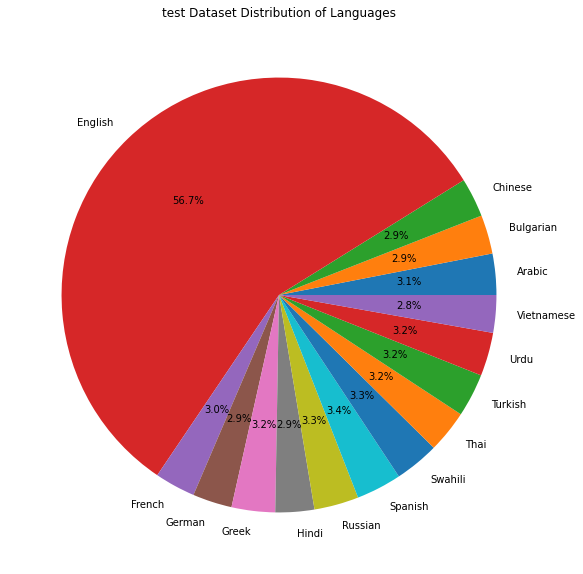

In [9]:
labels, frequencies = np.unique(test.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.title("test Dataset Distribution of Languages")
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

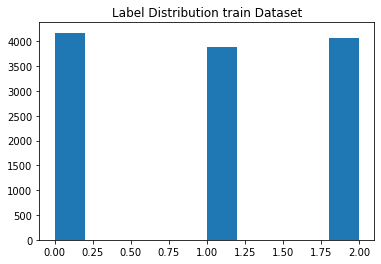

In [10]:
plt.hist(data=train,x='label')
plt.title("Label Distribution train Dataset")
plt.show()

The train target is balanced. 

## Prepare data for machine learning<a class="anchor" id="Prepare"></a>


In [12]:
#loading the mnli data set: https://huggingface.co/datasets/multi_nli
def load_mnli(use_validation=True):
    result = []
    dataset = load_dataset('multi_nli')
    print(dataset['train'])
    keys = ['train', 'validation_matched','validation_mismatched'] if use_validation else ['train']
    for k in keys:
        for record in dataset[k]:
            c1, c2, c3 = record['premise'], record['hypothesis'], record['label']
            if c1 and c2 and c3 in {0,1,2}:
                result.append((c1,c2,c3,'en'))
    result = pd.DataFrame(result, columns=['premise','hypothesis', 'label','lang_abv'])
    return result

In [13]:
mnli = load_mnli()

Downloading:   0%|          | 0.00/5.05k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.47k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/227M [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset multi_nli downloaded and prepared to /root/.cache/huggingface/datasets/multi_nli/plain_text/1.0.0/60774175381b9f3f1e6ae1028229e3cdb270d50379f45b9f2c01008f50f09e6b. Subsequent calls will reuse this data.
Dataset(features: {'premise': Value(dtype='string', id=None), 'hypothesis': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=3, names=['entailment', 'neutral', 'contradiction'], names_file=None, id=None)}, num_rows: 392702)


In [16]:
total_train = train[['id', 'premise', 'hypothesis','lang_abv', 'language', 'label']]
total_train

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2


In [17]:
mnli = mnli[['premise', 'hypothesis', 'lang_abv', 'label']]
mnli.insert(0, 'language', 'English')
mnli = mnli[['premise', 'hypothesis', 'lang_abv', 'language', 'label']]
mnli.insert(0, 'id', 'xxx')
mnli

,id,premise,hypothesis,lang_abv,language,label
0,xxx,Conceptually cream skimming has two basic dime...,Product and geography are what make cream skim...,en,English,1
1,xxx,you know during the season and i guess at at y...,You lose the things to the following level if ...,en,English,0
2,xxx,One of our number will carry out your instruct...,A member of my team will execute your orders w...,en,English,0
3,xxx,How do you know? All this is their information...,This information belongs to them.,en,English,0
4,xxx,yeah i tell you what though if you go price so...,The tennis shoes have a range of prices.,en,English,1
...,...,...,...,...,...,...
412344,xxx,Do you watch that?,Can you see?,en,English,2
412345,xxx,"To a Western ear, the most predictable of lang...","To the Western ear, the least predictable of l...",en,English,2
412346,xxx,The recorder captured the sounds of loud thump...,The recorder didn't capture any of the sounds.,en,English,2
412347,xxx,That's a good attitude!,"You feel good about this, don't you?",en,English,1


In [18]:
#conacting existed training datset with mnli datset 
total_train = pd.concat([total_train, mnli], axis = 0)
total_train

,id,premise,hypothesis,lang_abv,language,label
0,5130fd2cb5,and these comments were considered in formulat...,The rules developed in the interim were put to...,en,English,0
1,5b72532a0b,These are issues that we wrestle with in pract...,Practice groups are not permitted to work on t...,en,English,2
2,3931fbe82a,Des petites choses comme celles-là font une di...,J'essayais d'accomplir quelque chose.,fr,French,0
3,5622f0c60b,you know they can't really defend themselves l...,They can't defend themselves because of their ...,en,English,0
4,86aaa48b45,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสด...,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,th,Thai,1
...,...,...,...,...,...,...
412344,xxx,Do you watch that?,Can you see?,en,English,2
412345,xxx,"To a Western ear, the most predictable of lang...","To the Western ear, the least predictable of l...",en,English,2
412346,xxx,The recorder captured the sounds of loud thump...,The recorder didn't capture any of the sounds.,en,English,2
412347,xxx,That's a good attitude!,"You feel good about this, don't you?",en,English,1


In [19]:
train.describe(include='all')

,id,premise,hypothesis,lang_abv,language,label
count,12120,12120,12120,12120,12120,12120.000000
unique,12120,8209,12119,15,15,NaN
top,5130fd2cb5,and these comments were considered in formulat...,I am not sure.,en,English,NaN
freq,1,3,2,6870,6870,NaN
mean,NaN,NaN,NaN,NaN,NaN,0.990759
std,NaN,NaN,NaN,NaN,NaN,0.824523
min,NaN,NaN,NaN,NaN,NaN,0.000000
25%,NaN,NaN,NaN,NaN,NaN,0.000000
50%,NaN,NaN,NaN,NaN,NaN,1.000000
75%,NaN,NaN,NaN,NaN,NaN,2.000000


In [20]:
#using roberta xnli: This model takes xlm-roberta-large and fine-tunes it on a combination of NLI data in 15 languages.
#https://huggingface.co/joeddav/xlm-roberta-large-xnli?candidateLabels=%D8%A7%D9%84%D8%B3%D9%8A%D8%A7%D8%B3%D8%A9+%D8%A7%D9%84%D8%AE%D8%A7%D8%B1%D8%AC%D9%8A%D8%A9%2C+%D8%A3%D9%88%D8%B1%D9%88%D8%A8%D8%A7%2C+%D8%A7%D9%84%D8%A7%D9%86%D8%AA%D8%AE%D8%A7%D8%A8%D8%A7%D8%AA%2C+%D8%A7%D9%84%D8%A3%D8%B9%D9%85%D8%A7%D9%84%2C+%D8%A7%D9%84%D8%B3%D9%8A%D8%A7%D8%B3%D8%A9&multiClass=false&text=%D9%84%D9%85%D9%86+%D8%AA%D8%B5%D9%88%D8%AA+%D9%81%D9%8A+2020%D8%9F

model_name = "joeddav/xlm-roberta-large-xnli"
tokenizer = AutoTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

In [21]:
list(tokenizer.tokenize("I love machine learning"))

['▁I', '▁love', '▁machine', '▁learning']

In [23]:
#Tokenizers turn sequences of words into arrays of numbers
def encode_sentence(s):
    tokens = list(tokenizer.tokenize(s)) # FC: split the sentence into tokens that are either words or sub-words
    tokens.append('[SEP]') # FC: a token called [SEP] (=separator) is added to mark end of each sentence
    return tokenizer.convert_tokens_to_ids(tokens) # FC: instead of returning the list of tokens, a list of each token ID is returned

BERT(roberta) uses three kind of input data- input word IDs, input masks, and input type IDs.

These allow the model to know that the premise and hypothesis are distinct sentences, and also to ignore any padding from the tokenizer.

We add a [CLS] token to denote the beginning of the inputs, and a [SEP] token to denote the separation between the premise and the hypothesis. We also need to pad all of the inputs to be the same size. For more information about BERT inputs

In [25]:
def bert_encode(hypotheses, premises, tokenizer,max_len): # FC: for RoBERTa we remove the input_type_ids from the inputs of the model
    num_examples = len(hypotheses)
    sentence1 = tf.ragged.constant([encode_sentence(s) for s in np.array(hypotheses)])
    sentence2 = tf.ragged.constant([encode_sentence(s) for s in np.array(premises)])

    cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0] 
    input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1) 
    input_mask = tf.ones_like(input_word_ids).to_tensor(shape=[input_word_ids.shape[0], max_len])
    type_cls = tf.zeros_like(cls) # FC: creates a tensor same shape as cls with only zeros in it
    type_s1 = tf.zeros_like(sentence1)
    type_s2 = tf.ones_like(sentence2)
    input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor(shape=[input_word_ids.shape[0], max_len]) 
    
    inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask}
    
    return inputs

In [26]:
train_input = bert_encode(train.premise.values, train.hypothesis.values, tokenizer,120)

2022-11-02 10:44:00.608330: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-02 10:44:00.614139: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-02 10:44:00.614216: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-02 10:44:00.614281: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (622c0e8b0191): /proc/driver/nvidia/version does not exist
2022-11-02 10:44:00.620829: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [27]:
train_input

{'input_word_ids': <tf.Tensor: shape=(12120, 245), dtype=int32, numpy=
 array([[    3,   136,  6097, ...,     0,     0,     0],
        [    3, 32255,   621, ...,     0,     0,     0],
        [    3,  5581, 69332, ...,     0,     0,     0],
        ...,
        [    3,   581,  5526, ...,     0,     0,     0],
        [    3,  1913,    70, ...,     0,     0,     0],
        [    3,  1326, 66570, ...,     0,     0,     0]], dtype=int32)>,
 'input_mask': <tf.Tensor: shape=(12120, 120), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
total_train_input = bert_encode(total_train.premise.values, total_train.hypothesis.values, tokenizer,120)

## Building the Model <a class="anchor" id="model"></a>

In [ ]:
max_len = 120 

def build_model():

    encoder = TFAutoModel.from_pretrained('joeddav/xlm-roberta-large-xnli')
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids") 
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask") 

    embedding = encoder([input_word_ids, input_mask])[0] 
    
    
    output = tf.keras.layers.Dense(3, activation='softmax')(embedding[:,0,:])  
    model = tf.keras.Model(inputs=[input_word_ids, input_mask], outputs=output)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model 

In [ ]:
#set the TPU.

try:
    # detect and init the TPU
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver() 
    # instantiate a distribution strategy
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    
    strategy = tf.distribute.experimental.TPUStrategy(tpu) 
except ValueError: 
    strategy = tf.distribute.get_strategy() 
    print('Number of replicas:', strategy.num_replicas_in_sync) 

In [ ]:
with strategy.scope(): 
    model = build_model() 
    model.summary()       

tf.keras.utils.plot_model(model, "my_model.png", show_shapes=True)

In [ ]:
# We need to put the train set with the same size of the model
for key in train_input.keys():
    train_input[key] = train_input[key][:,:max_len]

In [ ]:
# We need to put the train set with the same size of the model
for key in total_train_input.keys():
    total_train_input[key] = total_train_input[key][:,:max_len]

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True)

In [ ]:
model.fit(total_train_input, total_train.label.values, epochs = 2, verbose = 1, validation_split = 0.2,batch_size=16*strategy.num_replicas_in_sync,callbacks=[early_stop])

In [ ]:
test = pd.read_csv("../input/contradictory-my-dear-watson/test.csv")
test_input = bert_encode(test.premise.values, test.hypothesis.values, tokenizer,120)

In [ ]:
for key in test_input.keys():
    test_input[key] = test_input[key][:,:max_len]

In [ ]:
test.head()

## Generating & Submitting Predictions<a class="anchor" id='Submitting'></a>

In [ ]:
predictions = [np.argmax(i) for i in model.predict(test_input)] 

In [ ]:
submission = test.id.copy().to_frame()
submission['prediction'] = predictions

In [ ]:
submission.head()

In [ ]:
submission.to_csv("submission.csv", index = False)

## Conclusion<a class="anchor" id='Conclusion'></a>

This project aimed to solve an NLI problem in 15 different languages. The original dataset was not enough to train the data to achieve high accuracy; therefore, another method was needed to achieve a higher accuracy score. With another dataset - the multi_nli dataset connected to the original dataset, and using the model xlm-roberta-large, the model achieved an accuracy score of ~92.